In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "figureS2-1"

# Multi-trait Gain as function of # siblings

## Longevity Model

In [294]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"), convert_to_cm=True)
longevity_data.rename(columns={"PGS": "Height_PGS"}, inplace=True)
longevity_data.head(2)

const  Gender  Age  Height_PGS  Height
FID IID                                        
2   427    1.0       0   61    0.000028  157.48
    448    1.0       1   62    0.000028  177.80

In [295]:
longevity_bmi_data = loaders.load_longevity_bmi_data(pgs_col=os.path.join(PGS_DIR, "longevity_bmi"), negate_bmi=False)
# longevity_bmi_data["BMI"] = 1 / longevity_bmi_data["BMI"]
longevity_bmi_data.rename(columns={"PGS": "BMI_PGS"}, inplace=True)
longevity_bmi_data = longevity_bmi_data[["BMI_PGS", "BMI"]]
longevity_data = longevity_data.merge(longevity_bmi_data, left_index=True, right_index=True)
longevity_data.head(3)

const  Gender  Age  Height_PGS  Height   BMI_PGS        BMI
FID IID                                                             
2   427    1.0       0   61    0.000028  157.48 -0.000056  27.454936
    448    1.0       1   62    0.000028  177.80 -0.000050  30.272873
11  615    1.0       0   64    0.000042  157.48 -0.000053  24.563013

#### Logenvity Height Model

In [296]:
height_model_covar = sm.OLS.from_formula("Height ~ Gender + Age", longevity_data).fit()
print("Covaraite model:", height_model_covar.rsquared)
longevity_data["Height_resid"] = height_model_covar.resid
height_model_pgs_res = sm.OLS.from_formula("Height_resid ~ Height_PGS", longevity_data).fit()
# print(height_model_pgs_res.summary())
print("PGS model:", height_model_pgs_res.rsquared)

Covaraite model: 0.6058148508038617
PGS model: 0.23920540192728923


#### Longevity BMI Model

In [297]:
# bmi_model_covar = sm.OLS.from_formula("BMI ~ Gender + Age + Age:Gender", longevity_data).fit()
bmi_model_covar = sm.OLS.from_formula("BMI ~ Gender + Age", longevity_data).fit()
print("Covaraite model:", bmi_model_covar.rsquared)
longevity_data["BMI_resid"] = bmi_model_covar.resid
bmi_model_pgs_res = sm.OLS.from_formula("BMI_resid ~ BMI_PGS", longevity_data).fit()
# print(height_model_pgs_res.summary())
print("PGS model:", bmi_model_pgs_res.rsquared)

Covaraite model: 0.024434791823445323
PGS model: 0.03101624361721622


## Prediction

In [299]:
longevity_so_50_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_50_height"), "Height_PGS")
longevity_so_50_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_50_height_pgs))
# longevity_so_50_height_pred.head(3)

In [300]:
longevity_so_50_bmi_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_50_bmi"), "BMI_PGS")
longevity_so_50_bmi_pred = bmi_model_pgs_res.predict(sm.add_constant(longevity_so_50_bmi_pgs))
# longevity_so_50_bmi_pred.head(3)

In [301]:
longevity_so_50_pred = pd.DataFrame({"Height": longevity_so_50_height_pred,
                                     "BMI": longevity_so_50_bmi_pred})
longevity_so_50_pred.head(3)

BMI    Height
FID       IID                     
1130_7342 SO00  0.737848  0.982134
          SO01  0.433465  2.818722
          SO02  1.224619  1.285201

### Trait weight

In [412]:
# trait_weights = 1 / longevity_so_50_pred.std()  # redundant due to siblings & synthetic
# trait_weights = 1 / pd.Series({"Height": height_model_pgs_res.model.endog.std(),
#                                "BMI": bmi_model_pgs_res.model.endog.std()})  # prefers better predicted traits
trait_weights = 1 / pd.Series({"Height": height_model_pgs_res.fittedvalues.std(),
                               "BMI": bmi_model_pgs_res.fittedvalues.std()})  # treats traits equally regardless of pred power

# # BMI trait lower is better so make it a negative (so next when selecting with height it would be consistent greater is better)
trait_weights["BMI"] *= -1

trait_weights

BMI      -1.285990
Height    0.334509
dtype: float64

In [303]:
longevity_so_50_pred = longevity_so_50_pred.join(longevity_so_50_pred * trait_weights, rsuffix="_std")
longevity_so_50_pred.head(3)

BMI    Height   BMI_std  Height_std
FID       IID                                           
1130_7342 SO00  0.737848  0.982134 -0.948866    0.328532
          SO01  0.433465  2.818722 -0.557431    0.942888
          SO02  1.224619  1.285201 -1.574848    0.429911

In [304]:
longevity_so_50_pred.std()

BMI           0.783082
Height        2.892856
BMI_std       1.007035
Height_std    0.967686
dtype: float64

### Trait correlation

In [305]:
# longevity_cov = longevity_data[["Height_PGS", "BMI_PGS"]].cov()
# # longevity_cov = longevity_data[["Height", "BMI"]].cov()
longevity_cov = pd.DataFrame({"Height_pred": height_model_pgs_res.fittedvalues, 
                              "BMI_pred": bmi_model_pgs_res.fittedvalues}).cov()
# longevity_cov = pd.DataFrame({"Height_pred": height_model_pgs_res.model.endog, 
#                               "BMI_pred": bmi_model_pgs_res.model.endog}).cov()
# longevity_cov = longevity_so_50_pred[["BMI", "Height"]].cov()
longevity_cov.rename(columns=lambda x: x.split("_")[0],
                     index=lambda x: x.split("_")[0], inplace=True)
longevity_cov

BMI    Height
BMI     0.604679 -0.370982
Height -0.370982  8.936857

In [306]:
# print("trait correlation:", height_model_pgs_res.fittedvalues.corr(bmi_model_pgs_res.fittedvalues))
longevity_corr = pd.DataFrame({"Height": height_model_pgs_res.fittedvalues, 
                               "BMI": bmi_model_pgs_res.fittedvalues}).corr()
longevity_corr

BMI    Height
BMI     1.000000 -0.159587
Height -0.159587  1.000000

## Compare to theoretical model

#### Sample increasing size families

In [307]:
def sample_subset(df, groupby_colname="FID"):
    res = {}
    max_fam_size = df.groupby(groupby_colname).size().iloc[0]
    for n in range(max_fam_size, 0, -1):
        df = df.groupby(groupby_colname).apply(lambda x: x.sample(n=n).reset_index("FID", drop=True))
        # reset_index() within each sample otherwise "FID" index multiplies and accumulates
        res[n] = df.copy()
    return res

In [498]:
longevity_so_pred = sample_subset(longevity_so_50_pred)

Negate the BMI before selecting to make greater values better:

In [278]:
# for i in longevity_so_pred.keys():
#     longevity_so_pred[i]["BMI"] *= -1
#     longevity_so_pred[i]["BMI_std"] *= -1

#### Calculate gain

In [329]:
def calculate_gain(dfs, convex_weight=0.5, groupby_colname="FID", greater_is_better=True):
    res = {}
    for n, df in dfs.items():
        df["mix"] = (convex_weight*df["Height_std"]) + ((1-convex_weight)*df["BMI_std"])
        df_gb = df.groupby(groupby_colname)
        res_by_selection = {}
#         for select_by in ["Height", "BMI", "mix"]:
        for select_by in ["Height_std", "BMI_std", "mix"]:
            if greater_is_better:
                best = df_gb[select_by].idxmax()
                gain = df.loc[best] - df_gb.mean()
            else:
                best = df_gb[select_by].idxmin()
                gain = df_gb.mean() - df.loc[best]
            gain = gain.agg(["mean", "sem", "std"]).T
            gain["ci95"] = stats.norm.ppf(0.95) * gain["sem"]
            res_by_selection[select_by] = gain
        res[n] = pd.concat(res_by_selection, names=["select", "trait"])
    res = pd.concat(res, names=["n_sibs"])
    return res

In [499]:
so_gain = calculate_gain(longevity_so_pred)
so_gain.sample(6)

mean       sem       std      ci95
n_sibs select     trait                                             
5      BMI_std    Height_std  0.068671  0.056585  0.565848  0.093074
9      mix        BMI_std     0.835079  0.046242  0.462419  0.076061
40     Height_std BMI        -0.159049  0.051140  0.511405  0.084119
19     Height_std Height      3.756326  0.105818  1.058180  0.174055
38     mix        BMI_std     1.094341  0.049239  0.492387  0.080990
3      BMI_std    BMI_std     0.551980  0.031429  0.314290  0.051696

#### Extract PG scores of current parents

In [311]:
def extract_parents_pgs(predictions, source_pgs, groupby_colnames):
    def map_iid_2_pgs(iid, source_pgs):
        try: 
            pgs = source_pgs.xs(iid, level="IID").iloc[0]
        except KeyError:
            pgs = np.nan
        return pgs
    # Simulations' FID contain parents IDs:
    parents = predictions.index.to_frame().reset_index(drop=True)
    # Filter the manny IIDs for each FID:
    parents = parents.groupby(groupby_colnames).first().index.to_frame().reset_index(drop=True)
    # Split the FID into its parents IID components:
    parents = parents.join(parents["FID"].str.split("_", expand=True).astype(int))
    # Convert the new parents IID component into their corresponding PG score:
    parents = parents.join(parents[[0, 1]].applymap(lambda x: map_iid_2_pgs(x, source_pgs)),
                           rsuffix="_pgs")
    return parents

parents_pgs = pd.concat({"Longevity height": extract_parents_pgs(longevity_so_50_height_pred, 
                                                                 longevity_data["Height_PGS"], ["FID"]),
                         "Longevity BMI": extract_parents_pgs(longevity_so_50_bmi_pred, 
                                                              longevity_data["BMI_PGS"], ["FID"])},
                        names=["set"])
parents_correlations = parents_pgs.groupby(["set"]).corr()
parents_correlations = parents_correlations.loc[pd.IndexSlice[:, "0_pgs"], "1_pgs"].rename("data")
parents_correlations.index = parents_correlations.index.droplevel(1)
parents_correlations = parents_correlations.to_frame().assign(no=0)
parents_correlations

data  no
set                           
Longevity BMI     0.023008   0
Longevity height -0.057619   0

In [521]:
pgs_models = {"Height": height_model_pgs_res, "BMI": bmi_model_pgs_res}
import pickle
with open(os.path.join(SAVE_FIG_DIR, "plot_data_5.pkl"), "wb") as fh:
    pickle.dump((so_gain, pgs_models, parents_correlations, trait_weights, longevity_corr), fh)
# with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "rb") as fh:
#     z = pickle.load(fh)

In [135]:
# import pickle
# with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "rb") as fh:
#     z = pickle.load(fh)
# so_gain, pgs_models, parents_correlations, trait_weights, longevity_corr = z

In [500]:
so_gain = so_gain.reorder_levels(["select", "trait", "n_sibs"])

In [501]:
so_gain = so_gain.rename(index=lambda x: x.split("_")[0], level="select")

### Plot

In [59]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)
else:
    sns.set_context("paper")
    plt.rcParams['xtick.major.pad']= '0'
    plt.rcParams['ytick.major.pad']= '1'
    plt.rcParams['legend.fontsize'] = '7.5'

In [61]:
def gauss_max_exp(n, approx=False, approx_scale=0.77):
    if approx:
        phi_max = np.sqrt(np.log(n)) * approx_scale
    else:
        gamma = 0.5772
        phi_max = stats.norm().ppf(1 - 1/n)
        phi_max += gamma / (n * stats.norm().pdf(phi_max))
    return phi_max

In [547]:
def single_plot_1y(empirical_gain, sm_model, trait, cov_mat, weights, corr_mat,
                   parents_correlation, single_trait_theory=False, approx_max=False,
                   dillute_ticks=False, color_ticklines=True, tick_units=False,
                   y_label=None, x_label=None, legend_loc=None, ax=None):
    legend_trait_name = "height" if trait == "Height" else trait
    ax = ax or plt.gca()
    empirical_gain = empirical_gain.reset_index("n_sibs")
    n_sibs_domain = np.linspace(1.5, empirical_gain["n_sibs"].max(), 100)
    
    # Plot gain by selecting on the trait
    gain_by_trait = empirical_gain.xs([trait, trait], level=["select", "trait"])
    gain_by_trait = gain_by_trait.sort_values("n_sibs")
    ax.plot(gain_by_trait["n_sibs"], gain_by_trait["mean"], 
            marker=".", label="Empirical, select for {}".format(legend_trait_name),
            color="C0")
    ax.fill_between(x=gain_by_trait["n_sibs"], 
                    y1=(gain_by_trait["mean"] - gain_by_trait["ci95"]), 
                    y2=(gain_by_trait["mean"] + gain_by_trait["ci95"]), 
                    alpha=0.2, label=None, color="C0")
    
    
    # Plot gain by selecting on a mix:
    gain_by_mixed = empirical_gain.xs(["mix", trait], level=["select", "trait"])
    gain_by_mixed = gain_by_mixed.sort_values("n_sibs")
    ax.plot(gain_by_mixed["n_sibs"], gain_by_mixed["mean"], 
            marker="s", markersize=4, color="C2",
            label="Empirical, select for mix")
    ax.fill_between(x=gain_by_mixed["n_sibs"], 
                    y1=(gain_by_mixed["mean"] - gain_by_mixed["ci95"]), 
                    y2=(gain_by_mixed["mean"] + gain_by_mixed["ci95"]), 
                    color="C2", alpha=0.2, label=None)
    
    
    # Plot single-trait Theoretical:
    if single_trait_theory:
        sigma_y = sm_model.model.endog.std()
        h_p = np.sqrt(sm_model.rsquared)
        rho = np.sqrt(1 - parents_correlation)
        expected_family_max = gauss_max_exp(n_sibs_domain, approx_max)
        theoretical_curve = sigma_y * h_p * expected_family_max * rho
        if not approx_max:
            theoretical_curve /= np.sqrt(2)
        if trait == "BMI":
            theoretical_curve *= -1
        ax.plot(n_sibs_domain, theoretical_curve, 
                label="Theoretical, select for {}".format(legend_trait_name), 
                color="C1", alpha=0.9)


    sigma_y = sm_model.model.endog.std()
    h_p = np.sqrt(sm_model.rsquared)
    sigma_y_hat = sigma_y * h_p  # == sm_model.fittedvalues.std() ==  1/np.abs(weights[trait])
    trait_corr = np.sqrt(1 + corr_mat.abs().iloc[0, 1])
    expected_family_max = gauss_max_exp(n_sibs_domain, approx_max)
    theoretical_curve = sigma_y_hat * trait_corr * expected_family_max / np.sqrt(2)
    if not approx_max:
        theoretical_curve /= np.sqrt(2)
    theoretical_curve *= np.sign(weights[trait])  # sign needs to be flipped for BMI which lower is better


    color = "C3" if single_trait_theory else "C1"
    ax.plot(n_sibs_domain, theoretical_curve, 
            label="Theoretical, select for mix", 
            alpha=0.9, color=color, zorder=2)
    
    
    ax.yaxis.set_tick_params(pad=1.5)
    ax.yaxis.labelpad = 1
    ax.xaxis.set_tick_params(pad=1.5)
    ax.xaxis.labelpad = 1.5

    # Edit:
    ax.fill_between(x=[], y1=[], y2=[], color="grey", alpha=0.2, label="95% CI")
    ax.legend(loc=legend_loc)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return ax

In [525]:
def plot_figure(gain, height_model, bmi_model, cov_mat, weights, corr_mat, parents_corr,
                single_trait_theory,
                approx_max, dillute_ticks, tick_units, 
                sd_scaled, sharey, plot_thickens=True, color_ticklines=True,
                legend_loc="lower right", figsize=(12, 5)):
    legend_loc = "lower right"
    xlabel = "# Embryos [n]"
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

    single_plot_1y(gain, height_model, "Height", cov_mat, weights, corr_mat,
                   parents_corr.loc["Longevity height"], single_trait_theory,
                   approx_max=approx_max,
                   dillute_ticks=dillute_ticks, color_ticklines=color_ticklines, 
                   tick_units=tick_units, legend_loc=legend_loc,
                   y_label="Gain [cm]", x_label=xlabel, ax=axes[0])
    axes[0].set_title("Height")

    single_plot_1y(gain, bmi_model, "BMI", cov_mat, weights, corr_mat,
                   parents_corr.loc["Longevity BMI"], single_trait_theory,
                   approx_max=approx_max,
                   dillute_ticks=dillute_ticks, color_ticklines=color_ticklines, 
                   tick_units=tick_units, legend_loc="upper right",
                   y_label="Gain [kg/m$^2$]", x_label=xlabel, ax=axes[1])
    axes[1].set_title("BMI")

    suptitle = "Multi-trait Gain as Function of Number of Embryos"
    if plot_thickens:
        fig.suptitle(suptitle, fontsize=18, y=1.03)
        fig.subplots_adjust(wspace=0.24)
    else:
        fig.suptitle(suptitle, fontsize=14, y=1.00)
        fig.subplots_adjust(wspace=0.3)

    if sd_scaled:
        axes[0].get_shared_y_axes().join(axes[0], axes[1], axes[2])
    if sharey:
        max_ylim = max([ax.get_ylim()[1] for ax in axes])
        min_ylim = min([ax.get_ylim()[0] for ax in axes])
        [ax.set_ylim(min_ylim, max_ylim) for ax in axes]
    
    return fig, axes

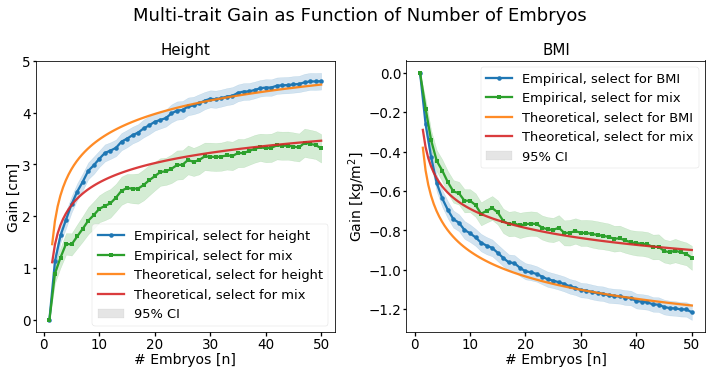

In [553]:
APPROX_MAX = True
DILLUTE_TICKS = False
UNIT_TICKS = False
SD_SCALED = False
SHAREY = False
pc="no"
SINGLE_TRAIT_THEORY = True
fig, axes_left = plot_figure(so_gain, height_model_pgs_res, bmi_model_pgs_res,
                             longevity_cov, trait_weights, longevity_corr, parents_correlations[pc],
                             SINGLE_TRAIT_THEORY,
                             APPROX_MAX, DILLUTE_TICKS, UNIT_TICKS, SD_SCALED, SHAREY)

In [554]:
file_name = ("multitrait-gain-by-nsibs" + 
            ("_1trait-thr" if SINGLE_TRAIT_THEORY else "") + 
            ("_thick" if PLOT_THICKENS else "") + 
            ("_approx" if APPROX_MAX else "") + 
            ("_pc-{}".format(pc)))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

multitrait-gain-by-nsibs_1trait-thr_thick_approx_pc-no


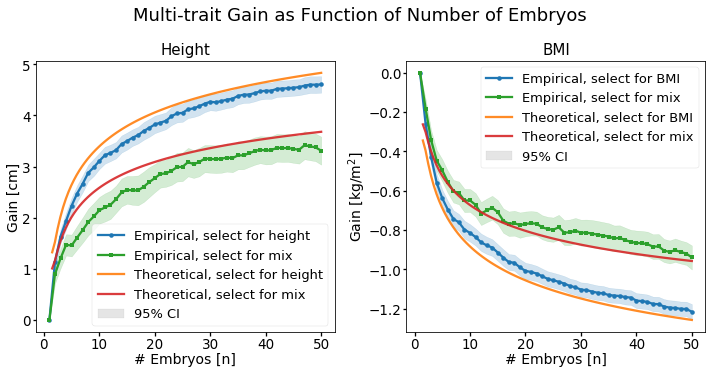

In [555]:
APPROX_MAX = False
DILLUTE_TICKS = False
UNIT_TICKS = False
SD_SCALED = False
SHAREY = False
pc = "no"
SINGLE_TRAIT_THEORY = True
fig, axes_left = plot_figure(so_gain, height_model_pgs_res, bmi_model_pgs_res,
                             longevity_cov, trait_weights, longevity_corr, parents_correlations[pc],
                             SINGLE_TRAIT_THEORY,
                             APPROX_MAX, DILLUTE_TICKS, UNIT_TICKS, SD_SCALED, SHAREY)

In [556]:
file_name = ("multitrait-gain-by-nsibs" + 
            ("_1trait-thr" if SINGLE_TRAIT_THEORY else "") + 
            ("_thick" if PLOT_THICKENS else "") + 
            ("_approx" if APPROX_MAX else "") + 
            ("_pc-{}".format(pc)))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

multitrait-gain-by-nsibs_1trait-thr_thick_pc-no
